In [1]:
import gym
from matplotlib import pyplot as plt
import math
import keyboard
from os import path,listdir
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageDraw
import pickle
import turtle

In [2]:
gym.envs.register(
    id='CartPole-v3',
    entry_point='gym.envs.classic_control:CartPoleEnv',
    max_episode_steps=2000      # MountainCar-v0 uses 200
)

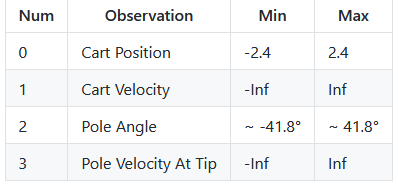

In [8]:
def calc_exit_time(observation):
    
    return (np.sign(observation[1])*2.4 - observation[0])/observation[1]

def calc_fall_time(observation):
    
    return (np.sign(observation[3])*0.066*math.pi - observation[2])/observation[3]

In [25]:
class MarkovAgent():
    
    def __init__(self):
        
        self.memory = []
        self.Qs = {}
        self.Ns = {}
        self.done = False
        self.gamma = 0.9
        self.epsilon = 1
        self.decay = 0.99
        
        self.session_score = 0
        self.max_distance = 0
        
        self.env = gym.make("CartPole-v3")
        
    def reset(self):
        
        self.done = False
        self.memory = []
        
    def play_session(self):
        
        observation = self.env.reset()
        
        self.session_score = 0
        self.max_distance = 0
        
        while not self.done:
            
            s,action = self.take_action(observation)
            observation, reward, self.done, info = self.env.step(action)
            self.session_score += 1            
            self.memory.append([s,-100 if self.done and self.session_score<2000 else reward,action])
            
            distance = observation[0]
            if abs(distance)>self.max_distance:
                self.max_distance = abs(distance)
        

            
        past_reward = 0
        
        for s, reward, action in reversed(self.memory):
            
            self.Qs[s][action] = (self.Qs[s][action]*self.Ns[s][action] + (reward + self.gamma*past_reward))/(self.Ns[s][action]+1)
            self.Ns[s][action] += 1
            past_reward = (reward + self.gamma*past_reward)
            
        self.epsilon = max(self.decay*self.epsilon,0.05)
        self.reset()
        
        
    def take_action(self,observation):
        
        s = np.asarray([round(observation[i],1+int(i/2)) for i in range(len(observation))]).tostring()
        if s not in self.Ns:
            
            self.Ns[s] = [5,5]
            self.Qs[s] = [100,100]
            
        q_list = self.Qs[s]
        
        if np.random.uniform(0,1)>self.epsilon:
            
            action = np.argmax(q_list)
            
        else:
            
            action = self.env.action_space.sample()
            
        return s,action
            
        
        

In [4]:
agent = MarkovAgent()

scores = []
means = []
distances = []

for i in tqdm(range(3000000)):
    
    agent.play_session()
    scores.append(agent.session_score)
    
    if len(scores)>=100:
        means.append(np.mean(scores[-100:]))
        
    distances.append(agent.max_distance)
    
    if i%10000==0:
        
        plt.scatter(distances[:-10000],scores[:-10000],s=1,c="blue")
        plt.scatter(distances[-10000:],scores[-10000:],s=1,c="red")
        plt.title("Score vs Max Distance")
        plt.xlim([0,2.4])
        plt.ylim([0,2001])
        plt.xlabel("Max Horizontal Distance")
        plt.ylabel("Score")
        plt.savefig(f'distances2/snapshot {i/10000}.png')
        plt.clf();


fig, axarr = plt.subplots(1,2,figsize=(15,7))

axarr[0].plot(scores,"blue")
axarr[0].set_title("Scores")
axarr[0].set_ylim([0,2001])

axarr[1].plot(means,"red")
axarr[1].set_title("Mean Scores")
axarr[1].set_ylim([0,2001]);

 88%|██████████████████████████████████████████████████████████        | 2638419/3000000 [19:44:48<31:13:55,  3.22it/s]

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

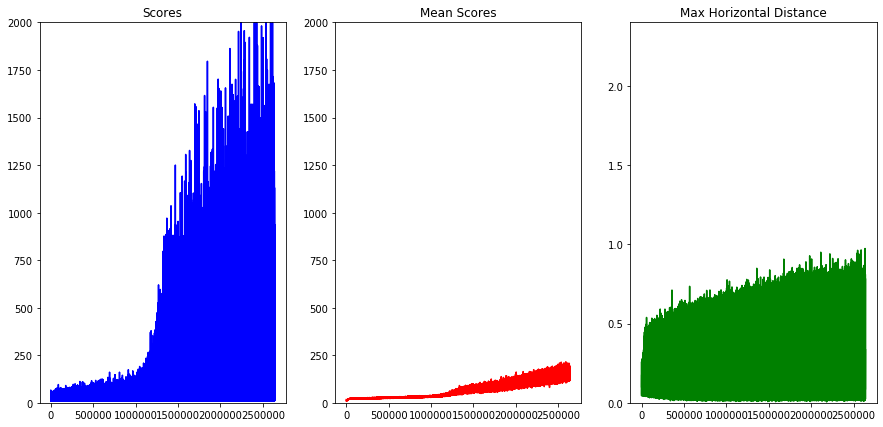

In [5]:
fig, axarr = plt.subplots(1,3,figsize=(15,7))

axarr[0].plot(scores,"blue")
axarr[0].set_title("Scores")
axarr[0].set_ylim([0,2001])

axarr[1].plot(means,"red")
axarr[1].set_title("Mean Scores")
axarr[1].set_ylim([0,2001])

axarr[2].plot(distances,"green")
axarr[2].set_title("Max Horizontal Distance")
axarr[2].set_ylim([0,2.4]);

In [5]:
import pandas as pd

In [7]:
means2 = pd.DataFrame(means)
scores2 = pd.DataFrame(scores)
means2.to_csv("means2.csv")
scores2.to_csv("scores2.csv")

In [ ]:
pickle.dump(agent,open("models/mark3.pkl","wb"))

In [2]:
im = Image.new('RGB', (432,288))
im.save('graphics/markov_distance2.gif', save_all=True, append_images=[Image.open(f'distances2/snapshot {i}.0.png') for i in range(len(listdir("distances/")))])

In [26]:
agent = pickle.load(open("models/mark.pkl","rb"))

In [16]:
observation = np.asarray([0,0,0,0]).tostring()
agent.Ns

{b'\x00\x00\x00\x00\x00\x00\x00\x80\x00\x00\x00\x00\x00\x00\x00\x00\xb8\x1e\x85\xebQ\xb8\x9e?\xb8\x1e\x85\xebQ\xb8\x9e?': [348,
  11536],
 b'\x00\x00\x00\x00\x00\x00\x00\x80\x9a\x99\x99\x99\x99\x99\xc9?\xb8\x1e\x85\xebQ\xb8\x9e?\x00\x00\x00\x00\x00\x00\xd0\xbf': [580,
  17451],
 b'\x00\x00\x00\x00\x00\x00\x00\x80\x9a\x99\x99\x99\x99\x99\xd9?{\x14\xaeG\xe1z\x94?H\xe1z\x14\xaeG\xe1\xbf': [11550,
  373],
 b'\x00\x00\x00\x00\x00\x00\x00\x80333333\xe3?{\x14\xaeG\xe1z\x84?=\n\xd7\xa3p=\xea\xbf': [210,
  29],
 b'\x00\x00\x00\x00\x00\x00\x00\x80\x9a\x99\x99\x99\x99\x99\xd9?\x00\x00\x00\x00\x00\x00\x00\x80\xf6(\\\x8f\xc2\xf5\xe0\xbf': [1830,
  104],
 b'\x00\x00\x00\x00\x00\x00\x00\x80333333\xe3?{\x14\xaeG\xe1z\x84\xbf=\n\xd7\xa3p=\xea\xbf': [124,
  33],
 b'\x00\x00\x00\x00\x00\x00\x00\x80\x9a\x99\x99\x99\x99\x99\xd9?\xb8\x1e\x85\xebQ\xb8\x9e\xbf\xf6(\\\x8f\xc2\xf5\xe0\xbf': [198,
  26],
 b'\x00\x00\x00\x00\x00\x00\x00\x00\x9a\x99\x99\x99\x99\x99\xc9?{\x14\xaeG\xe1z\xa4\xbf\x00\x00\x00\x00\x00\x

In [6]:
import array

In [7]:
xs = []
dxs = []
ws = []
dws = []
choices = []

for q in agent.Qs:
    
    ns = agent.Ns[q]
    
    if np.min(agent.Ns[q])>300:
        
        array = np.fromstring(q)
        
        xs.append(array[0])
        dxs.append(array[1])
        ws.append(array[2])
        dws.append(array[3])
        
        qs = agent.Qs[q]
        
        choice = 0 if qs[0]>qs[1] else 1
        choices.append(choice)
        
        
        
df = pd.DataFrame({"xs":xs,"dxs":dxs,"ws":ws,"dws":dws,"choice":choices})

P:\Users\Owner\Anaconda3\envs\bigbrain\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


In [9]:
from sklearn import svm

model = svm.SVC(kernel="linear")
model.fit(df[["ws","dws"]],df["choice"])

df["prediction"] = model.predict(df[["ws","dws"]])

In [9]:
w = model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-0.2, 0.2)
yy = a * xx - (model.intercept_[0]) / w[1]

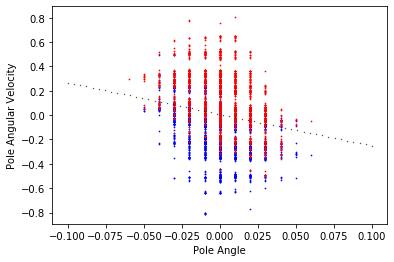

In [11]:
plt.scatter(df[df["choice"]==0]["ws"],df[df["choice"]==0]["dws"],s=0.5,c="blue")
plt.scatter(df[df["choice"]==1]["ws"],df[df["choice"]==1]["dws"],s=0.5,c="red")
plt.scatter(xx,yy,s=0.1,c="black")
plt.xlabel("Pole Angle")
plt.ylabel("Pole Angular Velocity")
plt.savefig(f'graphics/markov_decisionboundary.png');

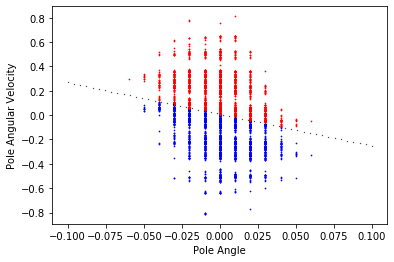

In [12]:
plt.scatter(df[df["prediction"]==0]["ws"],df[df["prediction"]==0]["dws"],s=0.5,c="blue")
plt.scatter(df[df["prediction"]==1]["ws"],df[df["prediction"]==1]["dws"],s=0.5,c="red")
plt.scatter(xx,yy,s=0.1,c="black")
plt.xlabel("Pole Angle")
plt.ylabel("Pole Angular Velocity")
plt.savefig(f'graphics/svm_decisionboundary.png');

In [13]:
pickle.dump(model,open("models/svm1.pkl","wb"))

In [8]:
model = pickle.load(open("models/svm1.pkl","rb"))

<Figure size 432x288 with 0 Axes>

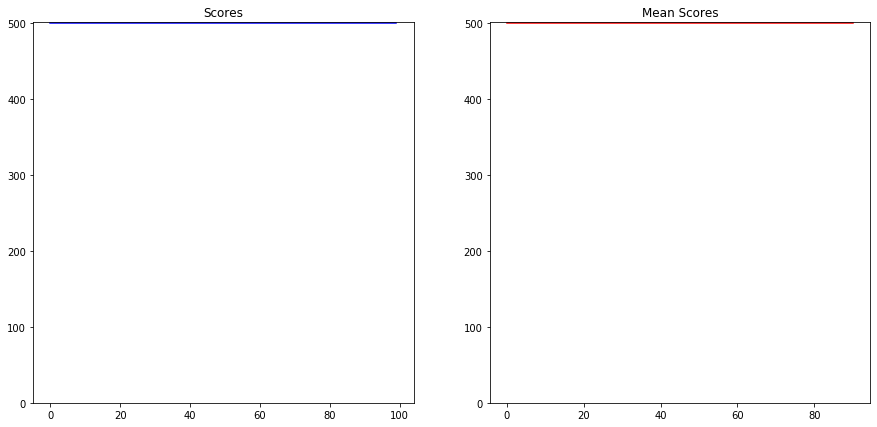

In [24]:
# SVM PERFORMANCE

env = gym.make("CartPole-v1")

scores = []
means = []
distances = []
ws = []
dws = []

for i in range(100):
    
    observation = env.reset()
        
    session_score = 0
    max_distance = 0
    done = False
    track = 0

    while not done:
        
        if i==5:
            
            tracking_stats = observation[2:]
            
            plt.scatter(tracking_stats[0],tracking_stats[1],s=3,c="green")
            plt.scatter(xx,yy,s=0.1,c="black")
            plt.title("Tracking SVM Performance")
            plt.xlim([-0.1,0.1])
            plt.ylim([-1,1])
            plt.xlabel("Pole Angle")
            plt.ylabel("Pole Angular Velocity")
            plt.annotate('Decision Boundary',(0.05,-0.1))
            plt.quiver(x,y,u,v,scale=40)
            plt.savefig(f'tracking_pole/test svm snapshot {track}.png')
            plt.clf();
            
            track += 1

        state = observation[2:].reshape(1,-1)
        action = model.predict(state)[0]


        observation, reward, done, info = env.step(action)
        session_score += 1

        distance = observation[0]
        if abs(distance)>max_distance:
            max_distance = abs(distance)
             
            
    scores.append(session_score)
    distances.append(max_distance)
    
    if len(scores)>=10:
        means.append(np.mean(scores[-10:]))       


    env.reset()

fig, axarr = plt.subplots(1,2,figsize=(15,7))

axarr[0].plot(scores,"blue")
axarr[0].set_title("Scores")
axarr[0].set_ylim([0,501])

axarr[1].plot(means,"red")
axarr[1].set_title("Mean Scores")
axarr[1].set_ylim([0,501]);

<Figure size 432x288 with 0 Axes>

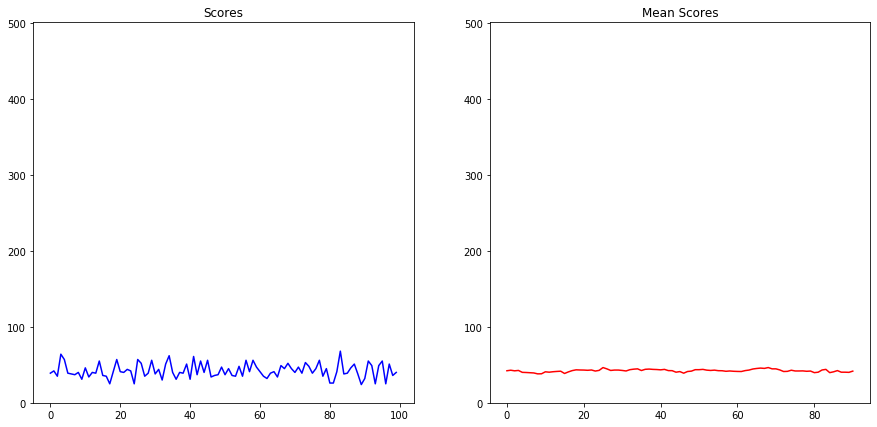

In [25]:
# HEURISTIC ONE PERFORMANCE

env = gym.make("CartPole-v1")


# env = gym.make("CartPole-v1")#, render_mode="rgb_array")
# env.metadata["render.modes"] = ["human", "rgb_array"]
# env = gym.wrappers.Monitor(env=env, directory="session videos/", force=True)

scores = []
means = []
distances = []
ws = []
dws = []

for i in range(100):
    
    observation = env.reset()
        
    session_score = 0
    max_distance = 0
    done = False
    track = 0

    while not done:
        
        if i==5:
            
            tracking_stats = observation[2:]
            
            plt.scatter(tracking_stats[0],tracking_stats[1],s=3,c="green")
            plt.scatter(xx,yy,s=0.1,c="black")
            plt.title("Tracking Heuristic 1 Performance")
            plt.xlim([-0.2,0.2])
            plt.ylim([-1.5,1.5])
            plt.xlabel("Pole Angle")
            plt.ylabel("Pole Angular Velocity")
            plt.annotate('Decision Boundary',(0.05,-0.1))
            plt.quiver(x,y,u,v,scale=40)
            plt.savefig(f'tracking_pole/test heuristic1 snapshot {track}.png')
            plt.clf();
            
            
            track += 1

        state = observation[2:].reshape(1,-1)
        angle = observation[2]
        action = 1 if angle>0 else 0


        observation, reward, done, info = env.step(action)
        session_score += 1

        distance = observation[0]
        
        if abs(distance)>max_distance:
            max_distance = abs(distance)
             
            
    scores.append(session_score)
    distances.append(max_distance)
    
    if len(scores)>=10:
        means.append(np.mean(scores[-10:]))       


    env.reset()

fig, axarr = plt.subplots(1,2,figsize=(15,7))

axarr[0].plot(scores,"blue")
axarr[0].set_title("Scores")
axarr[0].set_ylim([0,501])

axarr[1].plot(means,"red")
axarr[1].set_title("Mean Scores")
axarr[1].set_ylim([0,501]);

<Figure size 432x288 with 0 Axes>

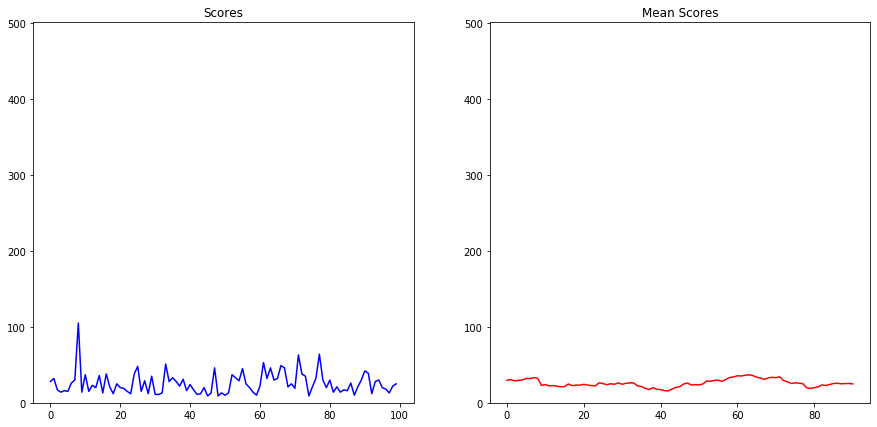

In [7]:
# HEURISTIC ZERO PERFORMANCE

env = gym.make("CartPole-v1")


# env = gym.make("CartPole-v1")#, render_mode="rgb_array")
# env.metadata["render.modes"] = ["human", "rgb_array"]
# env = gym.wrappers.Monitor(env=env, directory="session videos/", force=True)

scores = []
means = []
distances = []
ws = []
dws = []

for i in range(100):
    
    observation = env.reset()
        
    session_score = 0
    max_distance = 0
    done = False
    track = 0

    while not done:
        
        if i==5:
            
            tracking_stats = observation[2:]
            
            plt.scatter(tracking_stats[0],tracking_stats[1],s=3,c="green")
            plt.scatter(xx,yy,s=0.1,c="black")
            plt.title("Tracking Heuristic 1 Performance")
            plt.xlim([-0.2,0.2])
            plt.ylim([-1.5,1.5])
            plt.xlabel("Pole Angle")
            plt.ylabel("Pole Angular Velocity")
            plt.annotate('Decision Boundary',(0.05,-0.1))
            plt.quiver(x,y,u,v,scale=40)
            plt.savefig(f'tracking_pole/test heuristic0 snapshot {track}.png')
            plt.clf();
            
            
            track += 1

        state = observation[2:].reshape(1,-1)
        angle = observation[2]
        action = np.random.randint(0,2)


        observation, reward, done, info = env.step(action)
        session_score += 1

        distance = observation[0]
        
        if abs(distance)>max_distance:
            max_distance = abs(distance)
             
            
    scores.append(session_score)
    distances.append(max_distance)
    
    if len(scores)>=10:
        means.append(np.mean(scores[-10:]))       


    env.reset()

fig, axarr = plt.subplots(1,2,figsize=(15,7))

axarr[0].plot(scores,"blue")
axarr[0].set_title("Scores")
axarr[0].set_ylim([0,501])

axarr[1].plot(means,"red")
axarr[1].set_title("Mean Scores")
axarr[1].set_ylim([0,501]);

<Figure size 432x288 with 0 Axes>

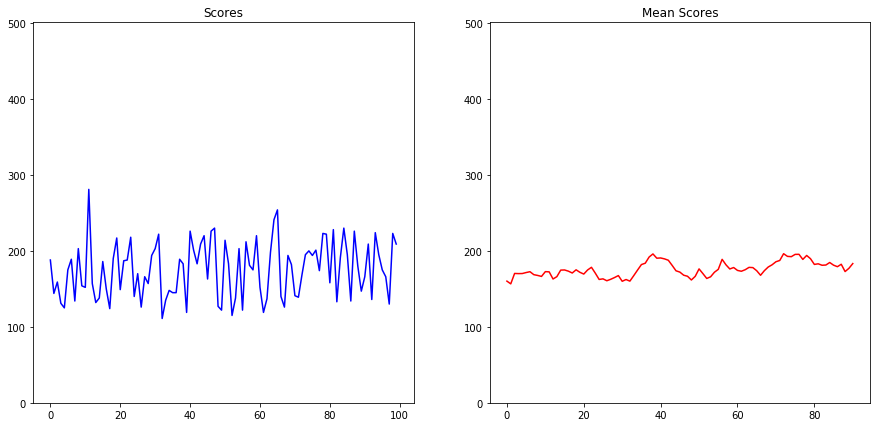

In [9]:
# HEURISTIC TWO PERFORMANCE

env = gym.make("CartPole-v1")


# env = gym.make("CartPole-v1")#, render_mode="rgb_array")
# env.metadata["render.modes"] = ["human", "rgb_array"]
# env = gym.wrappers.Monitor(env=env, directory="session videos/", force=True)

scores = []
means = []
distances = []
ws = []
dws = []

for i in range(100):
    
    observation = env.reset()
        
    session_score = 0
    max_distance = 0
    done = False
    track = 0

    while not done:
        
        if i==5:
            
            tracking_stats = observation[2:]
            
            plt.scatter(tracking_stats[0],tracking_stats[1],s=3,c="green")
            plt.scatter(xx,yy,s=0.1,c="black")
            plt.title("Tracking Heuristic 1 Performance")
            plt.xlim([-0.2,0.2])
            plt.ylim([-1.5,1.5])
            plt.xlabel("Pole Angle")
            plt.ylabel("Pole Angular Velocity")
            plt.annotate('Decision Boundary',(0.05,-0.1))
            plt.quiver(x,y,u,v,scale=40)
            plt.savefig(f'tracking_pole/test heuristic2 snapshot {track}.png')
            plt.clf();
            
            
            track += 1

        state = observation[2:].reshape(1,-1)
        angle = observation[2]
        
        
        fall_time = calc_fall_time(observation)
        exit_time = calc_exit_time(observation)
        
        if fall_time<exit_time:
            action = 1 if observation[3]>0 else 0
        else:
            action = 1 if observation[1]<0 else 0

        observation, reward, done, info = env.step(action)
        session_score += 1

        distance = observation[0]
        
        if abs(distance)>max_distance:
            max_distance = abs(distance)
             
            
    scores.append(session_score)
    distances.append(max_distance)
    
    if len(scores)>=10:
        means.append(np.mean(scores[-10:]))       


    env.reset()

fig, axarr = plt.subplots(1,2,figsize=(15,7))

axarr[0].plot(scores,"blue")
axarr[0].set_title("Scores")
axarr[0].set_ylim([0,501])

axarr[1].plot(means,"red")
axarr[1].set_title("Mean Scores")
axarr[1].set_ylim([0,501]);

In [28]:
im = Image.new('RGB', (800,600))
im.save('graphics/tracking_markov.gif', save_all=True, append_images=[Image.open(f'tracking_pole/markov {i}.png') for i in range(500)])

<Figure size 432x288 with 0 Axes>

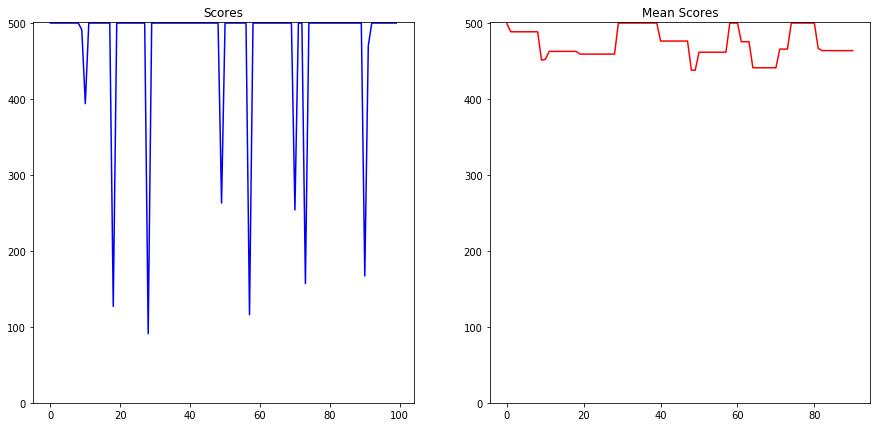

In [27]:
# MARKOV AGENT PERFORMANCE

env = gym.make("CartPole-v1")


# env = gym.make("CartPole-v1")#, render_mode="rgb_array")
# env.metadata["render.modes"] = ["human", "rgb_array"]
# env = gym.wrappers.Monitor(env=env, directory="session videos/", force=True)

scores = []
means = []
distances = []
ws = []
dws = []

for i in range(100):
    
    observation = env.reset()
        
    session_score = 0
    max_distance = 0
    done = False
    track = 0

    while not done:
        
        if i==5:
            
            tracking_stats = observation[2:]
            
            plt.scatter(tracking_stats[0],tracking_stats[1],s=3,c="green")
            plt.scatter(xx,yy,s=0.1,c="black")
            plt.title("Tracking Heuristic 1 Performance")
            plt.xlim([-0.2,0.2])
            plt.ylim([-1.5,1.5])
            plt.xlabel("Pole Angle")
            plt.ylabel("Pole Angular Velocity")
            plt.annotate('Decision Boundary',(0.05,-0.1))
            plt.quiver(x,y,u,v,scale=40)
            plt.savefig(f'tracking_pole/test markov snapshot {track}.png')
            plt.clf();
            
            
            track += 1

        
        s,action = agent.take_action(observation)
        

        observation, reward, done, info = env.step(action)
        session_score += 1

        distance = observation[0]
        
        if abs(distance)>max_distance:
            max_distance = abs(distance)
             
            
    scores.append(session_score)
    distances.append(max_distance)
    
    if len(scores)>=10:
        means.append(np.mean(scores[-10:]))       


    env.reset()

fig, axarr = plt.subplots(1,2,figsize=(15,7))

axarr[0].plot(scores,"blue")
axarr[0].set_title("Scores")
axarr[0].set_ylim([0,501])

axarr[1].plot(means,"red")
axarr[1].set_title("Mean Scores")
axarr[1].set_ylim([0,501]);

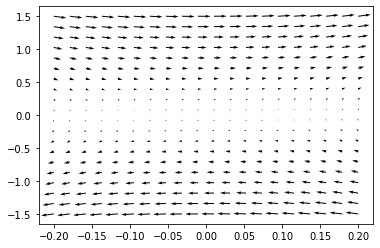

In [11]:
x,y = np.meshgrid(np.linspace(-0.2,0.2,20),np.linspace(-1.5,1.5,20))

speedx = x.copy()

for i in range(20):
    for j in range(20):
        
        speedx[i,j] = math.sin(speedx[i,j])

u = y
v = speedx

plt.quiver(x,y,u,v,scale=40)
plt.show()